# Preparation

In [1]:
!pip install -qU sentence-transformers==0.3.9
!pip install -qU wikipedia-api
!pip install -qU hazm
!pip install -qU clean-text[gpl]
!pip install -qU emoji
!pip install -qU bertopic

     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 1.3MB 7.3MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 890kB 48.7MB/s 
     |████████████████████████████████| 2.9MB 42.4MB/s 
     |████████████████████████████████| 317kB 4.3MB/s 
     |████████████████████████████████| 1.4MB 6.6MB/s 
     |████████████████████████████████| 235kB 18.2MB/s 
     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 245kB 5.1MB/s 
     |████████████████████████████████| 4.7MB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!apt-get install xz-utils -qy

Reading package lists...
Building dependency tree...
Reading state information...
xz-utils is already the newest version (5.2.2-1.3).
xz-utils set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [3]:
!mkdir resources
!wget -q "https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip" -P resources
!unzip -qq resources/resources-0.5.zip -d resources

In [4]:
!rm -rf /content/4ccae468eb73bf6c4f4de3075ddb5336
!rm -rf /content/preproc
!rm preprocessing.py utils.py
!mkdir -p /content/preproc
!git clone https://gist.github.com/4ccae468eb73bf6c4f4de3075ddb5336.git /content/preproc/
!mv /content/preproc/* /content/
!rm -rf /content/preproc

rm: cannot remove 'preprocessing.py': No such file or directory
rm: cannot remove 'utils.py': No such file or directory
Cloning into '/content/preproc'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [5]:
from preprocessing import cleaning
from utils import num_lines_in_file
from IPython import display

import nltk
import wikipediaapi

import numpy as np
import pandas as pd

import hazm
import requests
import time
from tqdm import tqdm
import json
from hazm import stopwords_list

import torch
from sentence_transformers import models, SentenceTransformer, util
from bertopic import BERTopic

In [6]:
def rtl_print(outputs, font_size="15px", n_to_br=False):
    outputs = outputs if isinstance(outputs, list) else [outputs] 
    if n_to_br:
        outputs = [output.replace('\n', '<br/>') for output in outputs]
        
    outputs = [f'<p style="text-align: right; direction: rtl; margin-right: 10px; font-size: {font_size};">{output}</p>' for output in outputs]
    display.display(display.HTML(' '.join(outputs)))


def load_st_model(model_name_or_path):
    word_embedding_model = models.Transformer(model_name_or_path)
    pooling_model = models.Pooling(
        word_embedding_model.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True,
        pooling_mode_cls_token=False,
        pooling_mode_max_tokens=False)
    
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    return model

# Topic Modeling

In [7]:
# VoA News
# Borrowed from https://jon.dehdari.org/corpora/#persian

!gdown https://drive.google.com/uc?id=1mBeSSrEnajB2qxYs67tQbEDWmpRMZ0U0
!unxz voa_fa_2003-2008_orig.txt.xz
!head -n 10 voa_fa_2003-2008_orig.txt

Downloading...
From: https://drive.google.com/uc?id=1mBeSSrEnajB2qxYs67tQbEDWmpRMZ0U0
To: /content/voa_fa_2003-2008_orig.txt.xz
10.4MB [00:00, 25.0MB/s]
# File: www.voanews.com/persian/archive/2003/2003-01/a-2003-01-01-12-1.cfm?textmode=0
# Date: 2003-01-01
# Headline: پيمان صلح بين ژاپن و روسيه
بنا به گزارشهای منتشره در توکيو، ژاپن و روسيه در زمينه يک پيمان صلح در چارچوبی گسترده توافق کرده اند که رسماً به مخاصمات جنگ دوم جهانی ميان دو کشور پايان خواهند داد.

در يکی از اين گزارشها، که از سوی خبرگزاری کيودُو،انتشار يافته، گفته شده است که دو کشور برای رفع اختلافات ديرين خود بر سر چهار جزيره از جزاير زنجيره ای کوريل، بر اساس سه پيمان گذشته خود عمل خواهند کرد.
بموجب يکی از اين پيمانها که در سال ۱۹۵۶ امضاء شده، دو تا از اين جزيره ها پس از امضاء يک پيمان صلح به ژاپن پس داده خواهد شد.
اما بموجب پيمانی که در سال ۱۹۹۳ به امضاء رسيده، مسئله حاکميت اين چهار جزيره بايستی پيش از امضاء پيمان صلح فيصله يابد.
هيچ يک از دو طرف نحوه استفاده از پيمان های پيشين را اعلام نکرده اند.



In [8]:
data = []
voa_corpus_path = '/content/voa_fa_2003-2008_orig.txt'

tmp_file = '# File:'
tmp_date = '# Date:'
tmp_headline = '# Headline:'
tmp_caption = '# Caption:'
counter = 0

with open(voa_corpus_path, encoding='utf-8') as f:
    _data = {'url': '', 'date': '', 'headline': '', 'caption': '', 'text': ''}
    texts = []

    for line in tqdm(f, total=num_lines_in_file(voa_corpus_path)):
        line = line.strip()

        if line.startswith(tmp_file):
            sp = line.split(tmp_file)
            sp = sp[-1].strip()
            _data['url'] = sp

            if counter > 0:
                _data['text'] = '\n'.join(texts).strip()
                data.append(_data)

                texts = []
                _data = {'url': '', 'date': '', 'headline': '', 'caption': '', 'text': ''}

        elif line.startswith(tmp_date):
            sp = line.split(tmp_date)
            sp = sp[-1].strip()
            _data['date'] = sp
        elif line.startswith(tmp_headline):
            sp = line.split(tmp_headline)
            sp = sp[-1].strip()
            _data['headline'] = sp
        elif line.startswith(tmp_caption):
            sp = line.split(tmp_caption)
            sp = sp[-1].strip()
            _data['caption'] = sp
        else:
            texts.append(line)

        counter += 1

100%|██████████| 566845/566845 [00:01<00:00, 367828.56it/s]


In [9]:
df = pd.DataFrame(data)
df = df[['text']]
df['text'] = df['text'].apply(lambda t: cleaning(t))
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print(f'We have #{len(df)} news!')
df.head()

We have #39210 news!


,text
0,بنا به گزارشهای منتشره در توکیو، ژاپن و روسیه ...
1,تشکیلات فلسطینی پس از دو سال نخستین بودجه رسمی...
2,پرزیدنت بوش میگوید وی شخصا اجازه جستجو برای یا...
3,مقامات فرانسوی میگویند روز شنبه یک مامور قسمت ...
4,یک مقام ایرانی می گوید صنعت هواپیمائی ایران در...


In [10]:
documents = df['text'].sample(frac=0.2).values.tolist()
print(f'We have #{len(documents)} news!')

We have #7842 news!


In [11]:
_model = load_st_model('m3hrdadfi/bert-fa-base-uncased-wikinli-mean-tokens')
_model.save('/content/bert-fa-base-uncased-wikinli-mean-tokens/')

In [12]:
model = BERTopic(
    '/content/bert-fa-base-uncased-wikinli-mean-tokens/', 
    stop_words=stopwords_list(),
    verbose=True)

topics, probabilities = model.fit_transform(documents)

2020-12-04 10:30:00,243 - BERTopic - Loaded BERT model
INFO:BERTopic:Loaded BERT model
2020-12-04 10:32:32,852 - BERTopic - Transformed documents to Embeddings
INFO:BERTopic:Transformed documents to Embeddings
2020-12-04 10:33:03,656 - BERTopic - Reduced dimensionality with UMAP
INFO:BERTopic:Reduced dimensionality with UMAP
2020-12-04 10:33:04,921 - BERTopic - Clustered UMAP embeddings with HDBSCAN
INFO:BERTopic:Clustered UMAP embeddings with HDBSCAN
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
len(model.get_topics().keys())

36

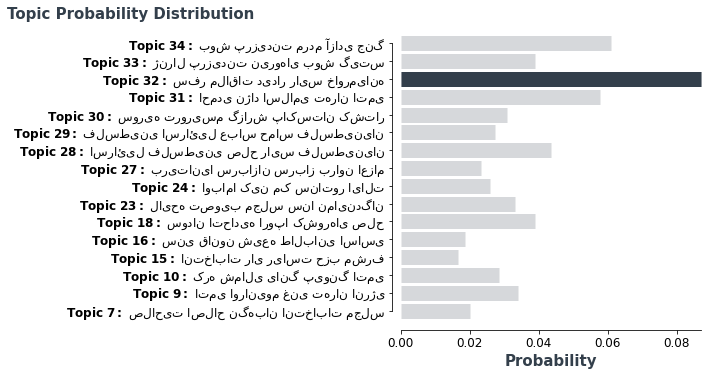

In [14]:
model.visualize_distribution(probabilities[0])

In [19]:
idx = np.random.randint(0, len(df))
sample_1 = df.iloc[idx]['text']
rtl_print(f'Document [{idx}]: {sample_1}')

In [20]:
topic_id = model.transform(sample_1)
predicted_topics = [f'{r[0]} --- Score: {r[1]:.3f}' for r in model.get_topic(topic_id[0][0])]
predicted_topics = '\n'.join(predicted_topics)

rtl_print(f"Predicted Topics:", font_size='18px')
rtl_print(' - - ' * 50)
rtl_print(predicted_topics, font_size='14px', n_to_br=True)

2020-12-04 10:35:20,136 - BERTopic - Loaded BERT model
INFO:BERTopic:Loaded BERT model
2020-12-04 10:35:20,329 - BERTopic - Transformed documents to Embeddings
INFO:BERTopic:Transformed documents to Embeddings


In [26]:
idx = np.random.randint(0, len(df))
sample_2 = df.iloc[idx]['text']
rtl_print(f'Document [{idx}]: {sample_2}')

In [27]:
topic_id = model.transform(sample_2)
predicted_topics = [f'{r[0]} --- Score: {r[1]:.3f}' for r in model.get_topic(topic_id[0][0])]
predicted_topics = '\n'.join(predicted_topics)

rtl_print(f"Predicted Topics:", font_size='18px')
rtl_print(' - - ' * 50)
rtl_print(predicted_topics, font_size='14px', n_to_br=True)

2020-12-04 10:35:49,454 - BERTopic - Loaded BERT model
INFO:BERTopic:Loaded BERT model
2020-12-04 10:35:49,647 - BERTopic - Transformed documents to Embeddings
INFO:BERTopic:Transformed documents to Embeddings
